In [2]:
#| echo: false
from IPython.display import display, Markdown


# Working with coolers

In this notebook, we use files generated by the workflow `master_workflow` that, in short, does the following:

1) Download the data from the source
2) Index the reference genome with `bwa index` and `samtools faidx`
3) Align the reads to the reference genome with `bwa mem`
4) Pair and sort the reads to `.pairs` files with `pairtools parse | pairtools sort`
5) Deduplicate the pairs with `pairtools dedup`
6) Convert the .pairs to cooler files with `cooler cload pairs`

We will:

1) Load the cooler files
2) Merge the coolers from the same BioSample ID --> Create 'replicates'
3) Zoomify the merged cooler files (coarsen) to create a multicooler (.mcool) file
4) Balance the matrices (use commandline `cooler balance`)
5) Calculate E1 compartments with `cooltools compute_cis_eig`

## Overview

### Data (Accessions)

In [3]:
#| echo: false
#| label: md-data-accessions
Markdown("""
To get an overview of the data accessions used in this analysis, we will first summarize the `SRA-runtable.tsv` that contains the accession numbers and some metadata for each sample (@tbl-runtable-summary).
""")


To get an overview of the data accessions used in this analysis, we will first summarize the `SRA-runtable.tsv` that contains the accession numbers and some metadata for each sample (@tbl-runtable-summary).


In [4]:
#| echo: false

import pandas as pd

df = pd.read_csv('../data/SraRunTable.txt')[['source_name','Run', 'BioSample', 'Bases','Bytes']].sort_values(['source_name', 'Run'])
df['GB'] = df['Bytes'].apply(lambda x: x / (1024 ** 3))
df['Reads'] = df['Bases']/300
df = df[['source_name', 'BioSample', 'Run', 'GB', 'Bases', 'Reads']]

# Use the style method to format the columns for display
df1 = df.style.format({'Bases': '{:,.0f}', 'Reads': '{:,.0f}'})

df_grouped = df.groupby('source_name').agg({'GB': 'sum', 'Bases': 'sum', 'Reads': 'sum'}).reset_index()
df_grouped = df_grouped.style.format({'Bases': '{:,.0f}', 'Reads': '{:,.0f}'})


In [5]:
#| echo: false
#| label: tbl-runtable
#| tbl-cap: "The most relevant columns of the `SRA-runtable.tsv` file"

display(df1)

,source_name,BioSample,Run,GB,Bases,Reads
16,fibroblast,SAMN08375237,SRR6502335,29.771059,"73,201,141,800","244,003,806"
17,fibroblast,SAMN08375237,SRR6502336,22.755361,"65,119,970,100","217,066,567"
18,fibroblast,SAMN08375236,SRR6502337,21.434722,"52,769,196,300","175,897,321"
19,fibroblast,SAMN08375236,SRR6502338,21.420030,"52,378,949,100","174,596,497"
20,fibroblast,SAMN08375236,SRR6502339,10.207410,"28,885,941,600","96,286,472"
9,fibroblast,SAMN08375237,SRR7349189,52.729173,"139,604,854,200","465,349,514"
10,fibroblast,SAMN08375236,SRR7349190,53.085520,"142,008,353,400","473,361,178"
21,pachytene spermatocyte,SAMN08375234,SRR6502342,60.258880,"150,370,993,500","501,236,645"
22,pachytene spermatocyte,SAMN08375234,SRR6502344,27.146048,"65,697,684,300","218,992,281"
23,pachytene spermatocyte,SAMN08375234,SRR6502345,26.202707,"63,490,538,700","211,635,129"


In [6]:
#| echo: false
#| label: tbl-runtable-summary
#| tbl-cap: "Summary of the data accessions used in this analysis"

display(df_grouped)

,source_name,GB,Bases,Reads
0,fibroblast,211.403275,"553,968,406,500","1,846,561,355"
1,pachytene spermatocyte,274.835160,"715,656,614,700","2,385,522,049"
2,round spermatid,243.128044,"655,938,457,200","2,186,461,524"
3,sperm,164.131640,"428,913,635,400","1,429,712,118"
4,spermatogonia,192.794420,"518,665,980,300","1,728,886,601"


### Folder structure

In [7]:
#| echo: false
#| label: md-folder-structure

Markdown("""
For ease of mind, here is the folder structure of the project. `../steps/bwa/PE/` is the base directory artificially defined in the `master_workflow.py`. It ccould be any other directory inside `steps`. It is defined relative to the `master_workflow.py` file (inside the worklow), and converted to an absolute path by python.
         """) 


For ease of mind, here is the folder structure of the project. `../steps/bwa/PE/` is the base directory artificially defined in the `master_workflow.py`. It ccould be any other directory inside `steps`. It is defined relative to the `master_workflow.py` file (inside the worklow), and converted to an absolute path by python.
         

In [ ]:
#| echo: false
#| label: folder-structure
#| fig-cap: "Folder structure of the project"

!tree -d -L 2 ../steps/bwa/PE


../steps/bwa/PE
├── bamfiles
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
├── cool
│   ├── fibroblast
│   ├── pachytene_spermatocyte
│   ├── round_spermatid
│   ├── sperm
│   └── spermatogonia
└── pairs
    ├── fibroblast
    ├── pachytene_spermatocyte
    ├── round_spermatid
    ├── sperm
    └── spermatogonia

18 directories


## FullMerge (pool all from each source_name)

In [10]:
#| echo: false
#| label: md-fullmerge-coolers

Markdown("""
We will use `cooler merge` to merge all samples in each sub-folder (cell type) to just one interaction matrix for each cell type. The reason for that is that we choose to trust [@wang_reprogramming_2019] when they say that compartments are highly reproducible between replicates, and by merging all replicates, we will have a more robust signal. 

Thus, we will merge all samples from the same source_name into a single cooler file. The coolers are produced to only contain the real chromosomes (1-22, X, Y), and not the mitochondrial DNA or the unplaced contigs (~2,900), as they would not bring any information to the analysis.

**Overview of this section:** 
         
- Locate the coolers (`glob` --> dictionary)
- Merge the coolers (`cooler.merge_coolers`)
- Zoomify the merged cooler (`cooler.zoomify_cooler`) to resolutions: 10kb, 50kb, 100kb, 500kb. 
- Balance the matrices (`!cooler balance`) (use the CLI, as it is more easily parallelized)
         """)


We will use `cooler merge` to merge all samples in each sub-folder (cell type) to just one interaction matrix for each cell type. The reason for that is that we choose to trust [@wang_reprogramming_2019] when they say that compartments are highly reproducible between replicates, and by merging all replicates, we will have a more robust signal. 

Thus, we will merge all samples from the same source_name into a single cooler file. The coolers are produced to only contain the real chromosomes (1-22, X, Y), and not the mitochondrial DNA or the unplaced contigs (~2,900), as they would not bring any information to the analysis.

**Overview of this section:** 
         
- Locate the coolers (`glob` --> dictionary)
- Merge the coolers (`cooler.merge_coolers`)
- Zoomify the merged cooler (`cooler.zoomify_cooler`) to resolutions: 10kb, 50kb, 100kb, 500kb. 
- Balance the matrices (`!cooler balance`) (use the CLI, as it is more easily parallelized)
         

### Create cooler dictionary (`glob`) 

In [33]:
#| echo: false
#| label: md-create-cooler-dict

Markdown("""
First, we will create a dictionary with the paths to the coolers for each sample. We use `glob.glob` to fetch all the coolers in each sub-folder that remain after filtering and (automatic) quality control (those are the ones with `nodups` in their names).
         """) 


First, we will create a dictionary with the paths to the coolers for each sample. We use `glob.glob` to fetch all the coolers in each sub-folder that remain after filtering and (automatic) quality control (those are the ones with `nodups` in their names).
         

In [16]:
import glob
import os.path as op
from pprint import pprint as pp
import pandas as pd

# Get the list of cell type dirs
base_dir = '../steps/bwa/PE/cool'
folders = glob.glob(op.join(base_dir, '*'))

files_dict = {f:glob.glob(f"{f}/*.nodups.*") for f in folders}
cooler_dict = {op.basename(k): [op.basename(f) for f in v] for k,v in files_dict.items()}
#pp(cooler_dict)
df = pd.DataFrame.from_dict(cooler_dict, orient='index').T.fillna('-')
df[['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']]

,fibroblast,spermatogonia,pachytene_spermatocyte,round_spermatid,sperm
0,SRR6502339.nodups.10000.cool,SRR6502357.nodups.10000.cool,SRR7345459.nodups.10000.cool,SRR7349192.nodups.10000.cool,SRR7349196.nodups.10000.cool
1,SRR7349190.nodups.10000.cool,SRR7345467.nodups.10000.cool,SRR6502344.nodups.10000.cool,SRR6502353.nodups.10000.cool,SRR6502362.nodups.10000.cool
2,SRR7349189.nodups.10000.cool,SRR6502356.nodups.10000.cool,SRR6502342.nodups.10000.cool,SRR6502352.nodups.10000.cool,SRR7349193.nodups.10000.cool
3,SRR6502335.nodups.10000.cool,SRR7345464.nodups.10000.cool,SRR7345458.nodups.10000.cool,SRR6502351.nodups.10000.cool,SRR6502360.nodups.10000.cool
4,SRR6502338.nodups.10000.cool,SRR7345462.nodups.10000.cool,SRR6502345.nodups.10000.cool,SRR7345460.nodups.10000.cool,SRR7349195.nodups.10000.cool
5,SRR6502336.nodups.10000.cool,SRR7345465.nodups.10000.cool,SRR7349191.nodups.10000.cool,SRR7345461.nodups.10000.cool,-
6,SRR6502337.nodups.10000.cool,SRR7345463.nodups.10000.cool,-,-,-


### Merge coolers

In [3]:
#| echo: false
#| label: md-merge-coolers

Markdown("""
The coolers are merged by summing each bin in the matrices, meaning we can only merge matrices with same dimensions.
We iterate through the dictionary and merge the coolers with `cooler merge`. The `mergebuf` parameter should be adjusted if you don't have 32G memory. Default: `mergebuf = 20000000`.
Below, we also check if the output file already exists. If it does, we skip the merge.         
        """)


The coolers are merged by summing each bin in the matrices, meaning we can only merge matrices with same dimensions.
We iterate through the dictionary and merge the coolers with `cooler merge`. The `mergebuf` parameter should be adjusted if you don't have 32G memory. Default: `mergebuf = 20000000`.
Below, we also check if the output file already exists. If it does, we skip the merge.         
        

In [5]:
# NB adjust `mergebuf` if you don't have 32G of RAM

import cooler

for folder,cooler_list in cooler_dict.items():
    in_uris = [op.join(base_dir, folder, file) for file in cooler_list]
    out_uri = op.join(base_dir, folder, f'{folder}.fullmerge.cool')

    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Creating {out_uri} by \nMerging {len(cooler_list)} coolers into one:", end=" ")
    print("\t",[file.split('.')[0] for file in cooler_list])
    cooler.merge_coolers(output_uri=out_uri,
                         input_uris=in_uris,
                         mergebuf=int(5e7),
                         )
    print("... Done!")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool: exists...
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.fullmerge.cool: exists...


### Zoomify the merged cooler files

In [9]:
#| echo: false
#| label: md-zoomify-coolers

Markdown("""
After merging the coolers, we will zoomify them to resolutions: 10kb, 50kb, 100kb, 500kb. It will recursively create the zoom levels for the cooler file from the 'base' resolution (in our case 10kb bins) to the 'max' resolution (in our case 500kb bins), and save all zoom levels in a multi-resolution cooler (`.mcool`) file. The resolutions are stored under the `resolutions` key in the cooler file (e.g. cell_type.mcool::/resolutions/10000). 

Here, we also check if the output file already exists. If it does, we skip the zoomify. Again, can tailor the `chunksize` (pixels loaded *per process*) parameter according to memory availability. I found that the command stalled completely (without quitting) when the memory allocation was not sufficient, as I started out with 32 cores and 32G of RAM. I did not test what was more time-efficient; increasing number of processes or chunksize. After all, it didn't take long to run anyways.
         
Finally, I list the resolutions in the mcool file.
         """)


After merging the coolers, we will zoomify them to resolutions: 10kb, 50kb, 100kb, 500kb. It will recursively create the zoom levels for the cooler file from the 'base' resolution (in our case 10kb bins) to the 'max' resolution (in our case 500kb bins), and save all zoom levels in a multi-resolution cooler (`.mcool`) file. The resolutions are stored under the `resolutions` key in the cooler file (e.g. cell_type.mcool::/resolutions/10000). 

Here, we also check if the output file already exists. If it does, we skip the zoomify. Again, can tailor the `chunksize` (pixels loaded *per process*) parameter according to memory availability. I found that the command stalled completely (without quitting) when the memory allocation was not sufficient, as I started out with 32 cores and 32G of RAM. I did not test what was more time-efficient; increasing number of processes or chunksize. After all, it didn't take long to run anyways.
         
Finally, I list the resolutions in the mcool file.
         

In [7]:
# NB 8 cores and 32G of RAM was used

import glob
import cooler
import os.path as op

base_dir = '../steps/bwa/PE/cool'
merged_coolers = glob.glob(op.join(base_dir, '*/*.fullmerge.cool'))


for clr in merged_coolers:
    out_uri = clr.replace('.fullmerge.cool', '.mcool')
    if op.exists(out_uri):
        print(f"Skipping {out_uri}: exists...")
        continue

    print(f"Zoomifying cooler: \n\t   {clr}\n\t-> {out_uri}", end="")
    
    cooler.zoomify_cooler(base_uris = clr,
                          outfile = out_uri,
                          resolutions = [10000,50000,100000,500000],
                          chunksize = 10000000,
                          nproc = 8)
    print(" --> done")

Skipping ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool: exists...
Skipping ../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool: exists...
Skipping ../steps/bwa/PE/cool/sperm/sperm.mcool: exists...
Zoomifying cooler: 
	   ../steps/bwa/PE/cool/fibroblast/fibroblast.fullmerge.cool
	-> ../steps/bwa/PE/cool/fibroblast/fibroblast.mcool --> done
Skipping ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool: exists...


In [ ]:
import glob
import cooler
mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")

for mcool in mcools:
    print(f"{mcool}:")
    print(cooler.fileops.list_coolers(mcool))
    print()


../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/sperm/sperm.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/fibroblast/fibroblast.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']

../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool:
['/resolutions/10000', '/resolutions/50000', '/resolutions/100000', '/resolutions/500000']



### Balance the matrices

In [40]:
#| echo: false
#| label: md-balance-coolers

Markdown("""
Finally, we balance the matrices using the cooler CLI. We use the `cooler balance` command with the default options using 32 cores, which iteratively balances the matrix (Iterative Corecction). It is first described as a method for bias correction of Hi-C matrices in [@imakaev_iterative_2012], where it is paired with eigenvector decomposition (ICE). Here the eigenvector decomposition of the obtained maps is shown to provide insights into local chromatin states. 

According to `cooler` documentation, we have to balance the matrices on each resolution, and thus it cannot be done prior to zoomifying. The argument is that the balancing weights are resolution-specific and will no longer retain its meaning when binned with other weights. Therefore, we use a nested for-loop that iterates through all the `.mcools` and all the resolutions in each `.mcool`. `cooler balance` will create a new column in the `bins` group of each cooler , `weight`, which can then be included or not in the downstream analysis. This means we will have access to both the balanced and the unbalanced matrix.
         
The default mode uses genome-wide data to calculate the weights for each bin. It would maybe be more suitable to calculate the weights for *cis* contacts only, and that is possible through the `--cis-only` flag, and that can be added to another column, so that we can compare the difference between the two methods easily. However, we will only use the default mode for now. The default options are:
         
- `ignore-diags: 2` (ignore the diagonals (-1,0,1))
- `mad-max: 5` (median absolute deviation threshold)
- `min-nnz: 10` (minimum number of non-zero entries before exclusion)

Conveniently, `cooler balance` automatically checks if there is already a `weight` column, and skips the balancing if it already exists. We can overwrite with `--force`.
        """)


Finally, we balance the matrices using the cooler CLI. We use the `cooler balance` command with the default options using 32 cores, which iteratively balances the matrix (Iterative Corecction). It is first described as a method for bias correction of Hi-C matrices in [@imakaev_iterative_2012], where it is paired with eigenvector decomposition (ICE). Here the eigenvector decomposition of the obtained maps is shown to provide insights into local chromatin states. 

According to `cooler` documentation, we have to balance the matrices on each resolution, and thus it cannot be done prior to zoomifying. The argument is that the balancing weights are resolution-specific and will no longer retain its meaning when binned with other weights. Therefore, we use a nested for-loop that iterates through all the `.mcools` and all the resolutions in each `.mcool`. `cooler balance` will create a new column in the `bins` group of each cooler , `weight`, which can then be included or not in the downstream analysis. This means we will have access to both the balanced and the unbalanced matrix.
         
The default mode uses genome-wide data to calculate the weights for each bin. It would maybe be more suitable to calculate the weights for *cis* contacts only, and that is possible through the `--cis-only` flag, and that can be added to another column, so that we can compare the difference between the two methods easily. However, we will only use the default mode for now. The default options are:
         
- `ignore-diags: 2` (ignore the diagonals (-1,0,1))
- `mad-max: 5` (median absolute deviation threshold)
- `min-nnz: 10` (minimum number of non-zero entries before exclusion)

Conveniently, `cooler balance` automatically checks if there is already a `weight` column, and skips the balancing if it already exists. We can overwrite with `--force`.
        

In [27]:
%%capture balance_out --no-stderr

import sys
import glob

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
resolutions = [10000, 50000, 100000, 500000]

for mcool in mcools:
    print(f"Balancing {mcool}:", file=sys.stderr)
    for res in resolutions:
        full_name = f"{mcool}::resolutions/{res}"
        print(f"\tresolution {res}...", end=" ", file=sys.stderr)
        # First, just default values
        !cooler balance -p 32 {full_name}
        # With only cis-contacts, save column seprately in the cooler file
        #!cooler balance -p 32 -c 20000000 --cis-only -n cis_weights {full_name}
        print("--> Done!", file=sys.stderr)

Balancing ../steps/bwa/PE/cool/round_spermatid/round_spermatid.mcool:
	resolution 10000... --> Done!
	resolution 50000... --> Done!
	resolution 100000... --> Done!
	resolution 500000... --> Done!
Balancing ../steps/bwa/PE/cool/spermatogonia/spermatogonia.mcool:
	resolution 10000... --> Done!
	resolution 50000... --> Done!
	resolution 100000... --> Done!
	resolution 500000... --> Done!
Balancing ../steps/bwa/PE/cool/sperm/sperm.mcool:
	resolution 10000... --> Done!
	resolution 50000... --> Done!
	resolution 100000... --> Done!
	resolution 500000... --> Done!
Balancing ../steps/bwa/PE/cool/fibroblast/fibroblast.mcool:
	resolution 10000... --> Done!
	resolution 50000... --> Done!
	resolution 100000... --> Done!
	resolution 500000... --> Done!
Balancing ../steps/bwa/PE/cool/pachytene_spermatocyte/pachytene_spermatocyte.mcool:
	resolution 10000... --> Done!
	resolution 50000... --> Done!
	resolution 100000... --> Done!
	resolution 500000... --> Done!


In [ ]:
# Display the balancing stdout if you want (but it is up to 200 lines per cooler)
balance_out()

'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already exists. Use --force option to overwrite.
'weight' column already e

## RepMerge (pool all from each BioSample ID)

In [21]:
#| echo: false
#| label: md-merge-replicates

Markdown("""
Initially, I planned to re-create the replicates that they used in the paper, but I reason that it is not necessary and might even be better to pool all the samples in stead. They state alredy that their compartments are highly repdoducible between replicates, so I choose to trust that and not bother with the replicates.

Therefore, this section was only briefly initialized, and now it is commented out.          

""")


Initially, I planned to re-create the replicates that they used in the paper, but I reason that it is not necessary and might even be better to pool all the samples in stead. They state alredy that their compartments are highly repdoducible between replicates, so I choose to trust that and not bother with the replicates.

Therefore, this section was only briefly initialized, and now it is commented out.          



In [1]:
#df.groupby(['source_name','BioSample'])['Reads'].sum()

In [2]:
# from pprintpp import pprint as pp

# grouped_df = df.groupby(['source_name','BioSample'])

# # Initialize an empty dictionary
# rep_dict = {}

# # Iterate over each group
# for (source_name, BioSample), group in grouped_df:
#     # Extract the 'Run' column and convert it to a list
#     run_list = group['Run'].tolist()
    
#     # Populate the nested dictionary
#     if source_name not in rep_dict:
#         rep_dict[source_name] = {}
#     rep_dict[source_name][BioSample] = run_list

# pp(rep_dict)

In [3]:
# for source_name, BioSample_dict in rep_dict.items():
#     print(f"source_name: {source_name}")
#     print(f"Changing working dir: {source_name}/")
#     for BioSample, run_list in BioSample_dict.items():
#         print(f"Merging samples for BioSample: {BioSample}: {run_list}")

# Plotting

In [ ]:
#| echo: false
#| label: md-plotting-main

from IPython.display import display, Markdown
Markdown("""
The following section contains the visualization of the matrices and includes the calculation of the E1 compartments and their visualization. I discuss differents methods for construction and try to get both methodologically and result-wise close to [@wang_reprogramming_2019].
         
First, we will work on matrices in 500kb resolution, as documentation [maybe it was HiCExplorer??] states it is sufficient for chromosome-wide analysis and plotting. We will follow the `cooltools`-recommended pipeline (except that they use a 100kb cooler) for [visualization](https://cooltools.readthedocs.io/en/latest/notebooks/viz.html) and [compartment calling](https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html) with one example cooler (the merged fibroblast cooler at 500kb resolution).

Then, the most relevant parts will be generalized to run in a loop over all the coolers. First at 500kb resolution, then at 100kb resolution.

To accomodate the approach (barely) described in the paper, we will discuss a smoothing step to the observed/expected matrices before compartment calling, and we will apply a smoothing step to the E1 compartments and compare to the raw compartments.
""")


The following section contains the visualization of the matrices and includes the calculation of the E1 compartments and their visualization. I discuss differents methods for construction and try to get both methodologically and result-wise close to [@wang_reprogramming_2019].
         
First, we will work on matrices in 500kb resolution, as documentation [maybe it was HiCExplorer??] states it is sufficient for chromosome-wide analysis and plotting. We will follow the `cooltools`-recommended pipeline (except that they use a 100kb cooler) for [visualization](https://cooltools.readthedocs.io/en/latest/notebooks/viz.html) and [compartment calling](https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html) with one example cooler (the merged fibroblast cooler at 500kb resolution).

Then, the most relevant parts will be generalized to run in a loop over all the coolers. First at 500kb resolution, then at 100kb resolution.

To accomodate the approach (barely) described in the paper, we will discuss a smoothing step to the observed/expected matrices before compartment calling, and we will apply a smoothing step to the E1 compartments and compare to the raw compartments.


## 500kb resolution

### Example with a single sample

In [28]:
#| echo: false
#| label: md-plotting-500kb-single

from IPython.display import display, Markdown

Markdown("""

First, I will explore the visualization pipeline for a single cooler at 500kb resolution. I will modify the plot to be 'stairs' in stead of just a regular line plot, as it is both a more accurate representation of the data and it is more aesthetically pleasing with less spiky lines and holes. 
         
In practice, the length of the dataframe is doubled, as it now contains an E1 value for both the start and end position for each bin in stead of only for the start. However, I first make the regular line plot to show the difference.

""") 



First, I will explore the visualization pipeline for a single cooler at 500kb resolution. I will modify the plot to be 'stairs' in stead of just a regular line plot, as it is both a more accurate representation of the data and it is more aesthetically pleasing with less spiky lines and holes. 
         
In practice, the length of the dataframe is doubled, as it now contains an E1 value for both the start and end position for each bin in stead of only for the start. However, I first make the regular line plot to show the difference.



#### Imports

In [2]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

In [3]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
import cooltools

#### Load cooler

In [4]:
mclr = "../steps/bwa/PE/cool/fibroblast/fibroblast.mcool"

clr = cooler.Cooler(f"{mclr}::resolutions/500000")

#### Calculate gc covariance (from the reference genome)

In [5]:
#| echo: false
#| label: md-plotting-500kb-single-gc

Markdown("""

I will use `bioframe` to load the reference and calculate the GC content of each bin in the cooler file. The convention in Hi-C is to use GC content as a phasing track to orient eigenvector track to positively correlated with the GC content. In this subsection, I calculate the GC content for all chromosomes and filter afterwards to only include the 'X' chromosome. I will do that smarter in the next subsection. 

""")



I will use `bioframe` to load the reference and calculate the GC content of each bin in the cooler file. The convention in Hi-C is to use GC content as a phasing track to orient eigenvector track to positively correlated with the GC content. In this subsection, I calculate the GC content for all chromosomes and filter afterwards to only include the 'X' chromosome. I will do that smarter in the next subsection. 



In [6]:
import bioframe
import os

bins = clr.bins()[:]
rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
gc_cov_csv = '../steps/rheMac10_gc_cov_500kb.tsv'
if not os.path.exists(gc_cov_csv):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(gc_cov_csv, index=False, sep='\t')
    display(gc_cov)
else: 
    print("Already exists, just read from file:")
    gc_cov = pd.read_csv(gc_cov_csv, sep='\t')
    display(gc_cov)

Already exists, just read from file:


,chrom,start,end,GC
0,chr1,0,500000,0.424508
1,chr1,500000,1000000,0.378836
2,chr1,1000000,1500000,0.388272
3,chr1,1500000,2000000,0.445226
4,chr1,2000000,2500000,0.439485
...,...,...,...,...
5715,chrY,9500000,10000000,0.399518
5716,chrY,10000000,10500000,0.396028
5717,chrY,10500000,11000000,0.395280
5718,chrY,11000000,11500000,0.382006


#### Calculate the E1 compartments

In [7]:
#| echo: false
#| label: md-plotting-500kb-single-e1

Markdown("""

Here, I will calculate the E1 compartments for the 'X' chromosome in the fibroblast cooler at 500kb resolution. I will use the `cooltools` package to do eigendecomposition and calculate the E1 compartments. I use the GC content (`gc_cov` obtained above) as a phasing track.  

I will only calculate the within-chromosomes compartmentalization (*cis* contacts). I use `cooltools.eigs_cis` that decorrelate the contact-frequency by distance before performing the eigendecomposition. 
         
I this example, I will use the simplest 'view' (chromosome-wide) of the chromosome to calculate the E1 values, but later I will explore how partitioning the chromosome affects the E1 values. As the GC content was calculated for all chromosomes, the eigenvectors are also calculated for the whole matrix. This will *also* be optimized in the next subsection, as we only ever look at the 'X' chromosome.

""") 



Here, I will calculate the E1 compartments for the 'X' chromosome in the fibroblast cooler at 500kb resolution. I will use the `cooltools` package to do eigendecomposition and calculate the E1 compartments. I use the GC content (`gc_cov` obtained above) as a phasing track.  

I will only calculate the within-chromosomes compartmentalization (*cis* contacts). I use `cooltools.eigs_cis` that decorrelate the contact-frequency by distance before performing the eigendecomposition. 
         
I this example, I will use the simplest 'view' (chromosome-wide) of the chromosome to calculate the E1 values, but later I will explore how partitioning the chromosome affects the E1 values. As the GC content was calculated for all chromosomes, the eigenvectors are also calculated for the whole matrix. This will *also* be optimized in the next subsection, as we only ever look at the 'X' chromosome.



In [8]:
# Make the full view frame
view_df = pd.DataFrame(
    {
    'chrom': clr.chromnames,
    'start': 0,
    'end': clr.chromsizes.values,
    'name': clr.chromnames
    }
                      )
#display(view_df)

In [9]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]
len(eigenvector_track)

5720

In [10]:
# full track
eigenvector_track

,chrom,start,end,E1
0,chr1,0,500000,-0.756052
1,chr1,500000,1000000,-1.001063
2,chr1,1000000,1500000,-0.928042
3,chr1,1500000,2000000,-0.507579
4,chr1,2000000,2500000,0.123708
...,...,...,...,...
5715,chrY,9500000,10000000,-0.499798
5716,chrY,10000000,10500000,-0.588820
5717,chrY,10500000,11000000,-0.988677
5718,chrY,11000000,11500000,-0.566585


In [11]:
#| echo: false
#| label: md-plotting-500kb-single-e1-X

Markdown("""

As I have made myself a detour and calculated the eigenvectors for all chromosomes, I will now filter the eigenvector track to only include the 'X' chromosome. Then, I will (in the name of explicitness) construct an array of all the indices where the E1 values change sign. This is the simplest way to save the coordinates of the compartment boundaries. It can later on be saved to .csv or whatever for comparison between different samples. Also, it will be simplified in the next subsection.
         
""") 



As I have made myself a detour and calculated the eigenvectors for all chromosomes, I will now filter the eigenvector track to only include the 'X' chromosome. Then, I will (in the name of explicitness) construct an array of all the indices where the E1 values change sign. This is the simplest way to save the coordinates of the compartment boundaries. It can later on be saved to .csv or whatever for comparison between different samples. Also, it will be simplified in the next subsection.
         


In [12]:
# subset the chrX   
eigenvector_track_chrX = eigenvector_track.loc[eigenvector_track['chrom'] == 'chrX']
nbins = len(eigenvector_track_chrX)
eigenvector_track_chrX
e1X_values = eigenvector_track_chrX['E1'].values

In [13]:
# Where does the E1 change sign
np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX']['E1']>0).astype(int)))[0]

array([  1,   6,  16,  26,  29,  40,  42,  49,  54,  55,  59,  60,  61,
        62,  74,  83,  86, 101, 102, 103, 104, 108, 123, 124, 129, 138,
       141, 142, 147, 149, 185, 188, 194, 196, 197, 201, 206, 209, 211,
       215, 222, 224, 228, 233, 238, 240, 250, 253, 256, 265, 273, 274,
       288, 289, 290, 293, 296, 302])

#### Plot E1 and matrix

In [25]:
#| echo: false
#| label: md-plotting-500kb-single-plot

Markdown("""

Finally, I will plot the matrix, the GC content, and the E1 compartments for the 'X' chromosome in the fibroblast cooler at 500kb resolution. I will use the `cooltools` package to plot the matrix and the compartments. I will use the `matplotlib` package to plot the GC content.
         
I will plot the matrix as a heatmap, the GC content as a line plot, and the E1 compartments as a line plot. I will also plot the compartment boundaries as vertical lines. The compartments are colored according to the sign of the E1 values. 
         
Following the `cooltools` recommendation, the colorbar itself will be log-transformed, as otherwise the balanced interaction matrix (values from 0 to 1) will be hard to interpret. The E1 values are (as is the colorbar) added to the axis with an `AxesDivider.append_axes` object to make them match the axes of the matrix.

I'm testing out the `%%capture` magic to capture the plot to a variable, then displaying it in the next cell. Initially, the plot took a while to generate, and I wanted to avoid re-generating when adjusting graphics on cell level with the YAML options. Now it is not necessary, but I keep it for the sake of the example.
         
""")



Finally, I will plot the matrix, the GC content, and the E1 compartments for the 'X' chromosome in the fibroblast cooler at 500kb resolution. I will use the `cooltools` package to plot the matrix and the compartments. I will use the `matplotlib` package to plot the GC content.
         
I will plot the matrix as a heatmap, the GC content as a line plot, and the E1 compartments as a line plot. I will also plot the compartment boundaries as vertical lines. The compartments are colored according to the sign of the E1 values. 
         
Following the `cooltools` recommendation, the colorbar itself will be log-transformed, as otherwise the balanced interaction matrix (values from 0 to 1) will be hard to interpret. The E1 values are (as is the colorbar) added to the axis with an `AxesDivider.append_axes` object to make them match the axes of the matrix.

I'm testing out the `%%capture` magic to capture the plot to a variable, then displaying it in the next cell. Initially, the plot took a while to generate, and I wanted to avoid re-generating when adjusting graphics on cell level with the YAML options. Now it is not necessary, but I keep it for the sake of the example.
         


In [42]:
%%capture chrX_matrix_e1_500kb

from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("top", size="20%", pad=0.05, sharex=ax)
#weights = clr.bins()[:]['weight'].values
#ax1.plot([0,nbins],[0,0],'k',lw=0.25)

#ax1.plot(e1X_values, label='E1')

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

ax1.set_ylabel('E1')
ax1.set_xticks([]);
ax1.get_subplotspec()


for i in np.where(np.diff( (cis_eigs[1][cis_eigs[1]['chrom']=='chrX']['E1']>0).astype(int)))[0]:
    # Horisontal lines where E1 intersects 0
    ax.plot([0,nbins],[i,i],'k',lw=0.4)

    # Vertical lines where E1 intersects 0
    ax.plot([i,i],[0,nbins],'k',lw=0.4)

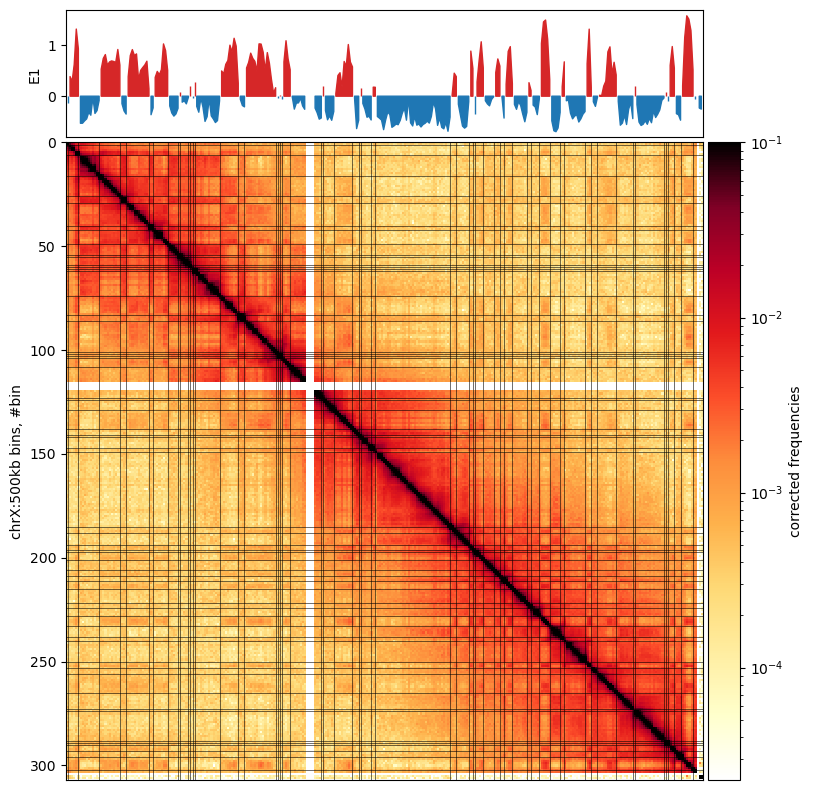

In [43]:
#| label: fig-chrX_matrix_e1_500kb
#| fig-cap: "chrX interaction matrix with E1 eigenvector values in 500kb resolution. The sign change of the E1 is overlayed as thin black lines, making it more easily interpretable. We should qualitatively determine how well the E1 values capture the *plaid* pattern in the matrix."  

chrX_matrix_e1_500kb()

Markdown: @fig-chrX_matrix_e1_500kb

In [45]:
#| echo: false
#| label: md-plotting-500kb-single-plot-discussion

Markdown("""

We observe that the E1 values only somewhat captures the plaid pattern in the matrix @fig-chrX_matrix_e1_500kb, but it is not related to the size of the compartments, as both small and large compartments can be observed. The B-compartment that starts from around bin 150 (75.000.000 bp) seems to have squares that are not captured by the E1 values. Maybe it could be captures by TAD calling, but that is not the scope of this analysis.

""") 



We observe that the E1 values only somewhat captures the plaid pattern in the matrix @fig-chrX_matrix_e1_500kb, but it is not related to the size of the compartments, as both small and large compartments can be observed. The B-compartment that starts from around bin 150 (75.000.000 bp) seems to have squares that are not captured by the E1 values. Maybe it could be captures by TAD calling, but that is not the scope of this analysis.



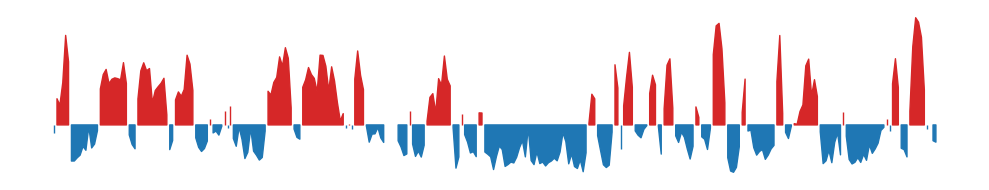

In [46]:
#| label: chrX-e1-500kb-plot
#| fig-cap: "500kb binned E1 eigenvector values for chrX. Freshly calculated from the cooler file."
#| fig-height: 1


import matplotlib.pyplot as plt

f, ax1 = plt.subplots(
    figsize=(10, 2),
)

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

#ax1.set_ylabel('E1')
ax1.set_xticks([])
ax1.set_yticks([])

# Remove borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

plt.tight_layout()

# Save the plot as a SVG file
#plt.savefig('e1_plot.svg', bbox_inches='tight')

plt.show()

Markdown the next plot: @chrX-e1-500kb-plot

#### Stairs plot of the E1 compartments

(Less spiky, more smooth)



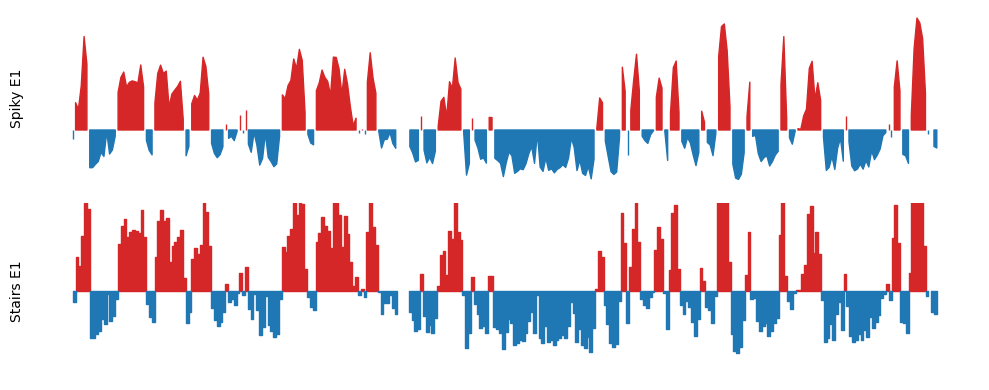

In [ ]:
#| label: chrX-e1-500kb-stairs
#| fig-cap: "500kb binned E1 eigenvector values for chrX."
#| fig-height: 2


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2,1,
    figsize=(10, 4)
)

chrom_start = eigenvector_track_chrX['start'].values
window_size = chrom_start[1] - chrom_start[0]

# Fill between the line and 0
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values > 0), color='tab:red')
ax1.fill_between(range(len(e1X_values)), e1X_values, 0, where=(e1X_values < 0), color='tab:blue')

# Create stairs
x = np.zeros(2*chrom_start.size)
y = np.zeros(2*chrom_start.size)
x[0::2] = chrom_start
x[1::2] = chrom_start + window_size
y[0::2] = e1X_values
y[1::2] = e1X_values

# Layout
ax1.set_ylabel('Spiky E1')
ax2.set_ylabel('Stairs E1')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-1, 1)

# Remove borders
ax1.spines[:].set_visible(False)
ax2.spines[:].set_visible(False)

ax2.fill_between(x, y, 0, where=(y > 0), color='tab:red')
ax2.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

plt.tight_layout()
# Save the plot as a high-resolution PNG file
#plt.savefig('../steps/e1_plot.png', dpi=320, bbox_inches='tight')



### All 5 full merges

#### Load coolers

In [41]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/500000"

clrs = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs = {key: clrs[key] for key in chron_order}
clrs

{'fibroblast': <Cooler "fibroblast.mcool::/resolutions/500000">,
 'spermatogonia': <Cooler "spermatogonia.mcool::/resolutions/500000">,
 'pachytene_spermatocyte': <Cooler "pachytene_spermatocyte.mcool::/resolutions/500000">,
 'round_spermatid': <Cooler "round_spermatid.mcool::/resolutions/500000">,
 'sperm': <Cooler "sperm.mcool::/resolutions/500000">}

#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [42]:
# Try with only the gc_cov for chrX

import bioframe
import pandas as pd
import os.path as op

bins = clrs['fibroblast'].bins().fetch('chrX')[:]
out_name = '../steps/rheMac10_gc_cov_X_500kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   307 non-null    object 
 1   start   307 non-null    int64  
 2   end     307 non-null    int64  
 3   GC      307 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 9.7+ KB
None


#### Calculate the E1 compartments

Loop: view_df, cis_eigs, e1_values

##### Plot GC covariance

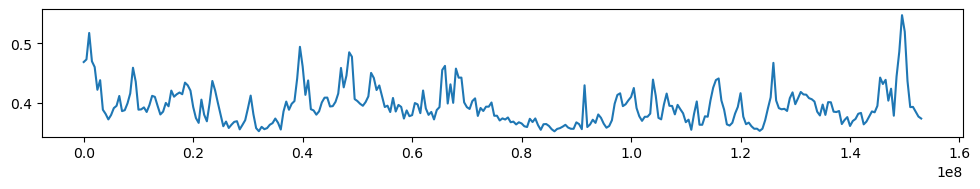

In [43]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(
    figsize=(10, 2),
)

ax.plot(gc_cov['start'],gc_cov['GC'])

plt.tight_layout()

##### Chromosome restricted E1 compartments

In [44]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools
import pandas as pd

eigs_full = {}
e1_values_full = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

# Divide into chromosome arms
clr = clrs['fibroblast']
view_df_full = pd.DataFrame(
    {
    'chrom': 'chrX',
    'start': 0,
    'end': chrX_size,
    'name': 'chrX'
    }, index=[0]
                      )

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}, size {clr.binsize}")
    cis_eigs_full = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df_full,
                        n_eigs=3,
                        )
    eigs_full[name] = cis_eigs_full[1]
    e1_track_full = cis_eigs_full[1][['chrom','start','end','E1']]
    e1_values_full[name] = e1_track_full['E1'].values

#eigs

Calculating eigenvectors for fibroblast, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm, size 500000


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


##### Chromosome arms restricted

In [45]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools
import pandas as pd

eigs = {}
e1_values = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

# Divide into chromosome arms
view_df = pd.DataFrame(
    {
    'chrom': 'chrX',
    'start': [0, 59_000_001],
    'end': [59_000_000, chrX_size],
    'name': ['X_short', 'X_long']
    }, index=[0,1]
                      )

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}")
    cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )
    eigs[name] = cis_eigs[1]
    e1_track = cis_eigs[1][['chrom','start','end','E1']]
    e1_values[name] = e1_track['E1'].values

#eigs

Calculating eigenvectors for fibroblast
Calculating eigenvectors for spermatogonia


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte
Calculating eigenvectors for round_spermatid


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")
/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


##### Refined: 10Mb windows restricted

In [46]:
# Use gc_cov to calculate eigenvectors with cooltools.eigs_cis

import cooltools

eigs_10mb = {}
e1_values_10mb = {}

chrX_size = clrs['fibroblast'].chromsizes['chrX']

# Calculate in 1Mb windows
# Define the window size (1Mb)

window_size = 10_000_000

# Generate the start and end positions for each window
start_positions = list(range(0, chrX_size, window_size))
end_positions = [min(start + window_size, chrX_size) for start in start_positions]
# Create the DataFrame
view_df_10mb = pd.DataFrame({
    'chrom': ['chrX'] * len(start_positions),
    'start': start_positions,
    'end': end_positions,
    'name': [f'X_{i}' for i in range(len(start_positions))]
})
#display(view_df)

for name, clr in clrs.items():
    print(f"Calculating eigenvectors for {name}")
    cis_eigs_10mb = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df_10mb,
                        n_eigs=3,
                        )
    eigs_10mb[name] = cis_eigs_10mb[1]
    e1_track_10mb = cis_eigs_10mb[1][['chrom','start','end','E1']]
    e1_values_10mb[name] = e1_track_10mb['E1'].values

#eigs

Calculating eigenvectors for fibroblast


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


##### Plot NaN histogram

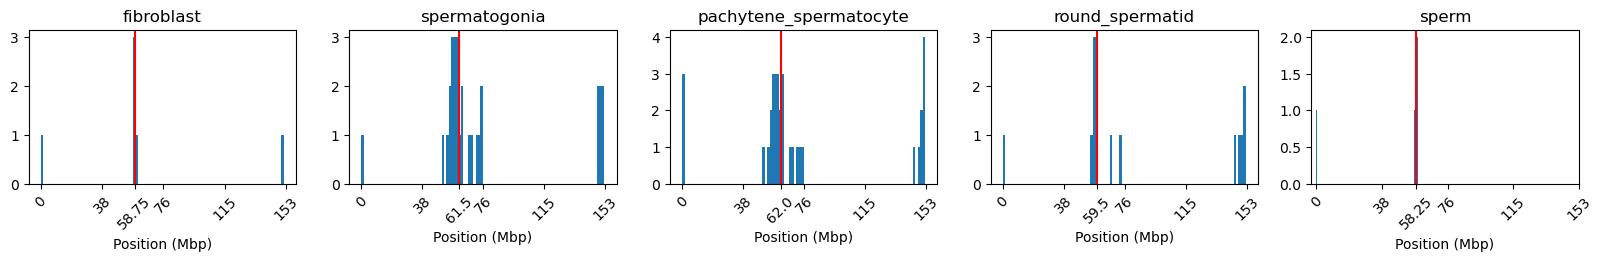

In [47]:
#| label: e1_nan_hist
#| fig-cap: "Histogram of NaN values in the E1 eigenvector for each cell type."
#| column: page-inset

# Check the number of NaN values in the E1 column
import numpy as np

# Check the number of NaN values in the E1 column and create a DataFrame
nan_counts = {k: {'length': len(v), 'NaNs': np.isnan(v).sum()} for k, v in e1_values.items()}
#display(pd.DataFrame.from_dict(nan_counts, orient='index'))

# Locate the NaN values (histogram)
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 5, figsize=(20,2))
for i, (name, track) in enumerate(eigs.items()):
    e1 = track['E1'].values
    # Locate NaN values
    e1_nan = np.where(np.isnan(e1))
    # Plot histogram
    ax[i].hist(e1_nan, bins=100)
    
    # Plot median line
    median_pos = np.median(e1_nan)
    ax[i].axvline(median_pos, color='r')

    # Layout
    ax[i].set_title(name)
    xticks = np.linspace(0, len(e1), num=5)
    xticks = np.append(xticks, median_pos)  # Add median position to xticks
    ax[i].set_xticks(xticks)
    xticklabels = np.linspace(0, len(e1) * 0.5, num=5, dtype = 'int').tolist()
    xticklabels.append(median_pos*0.5)  # Add median label
    ax[i].set_xticklabels(xticklabels, rotation=45)
    ax[i].set_xlabel('Position (Mbp)')
                     

#### Plot the E1 compartments

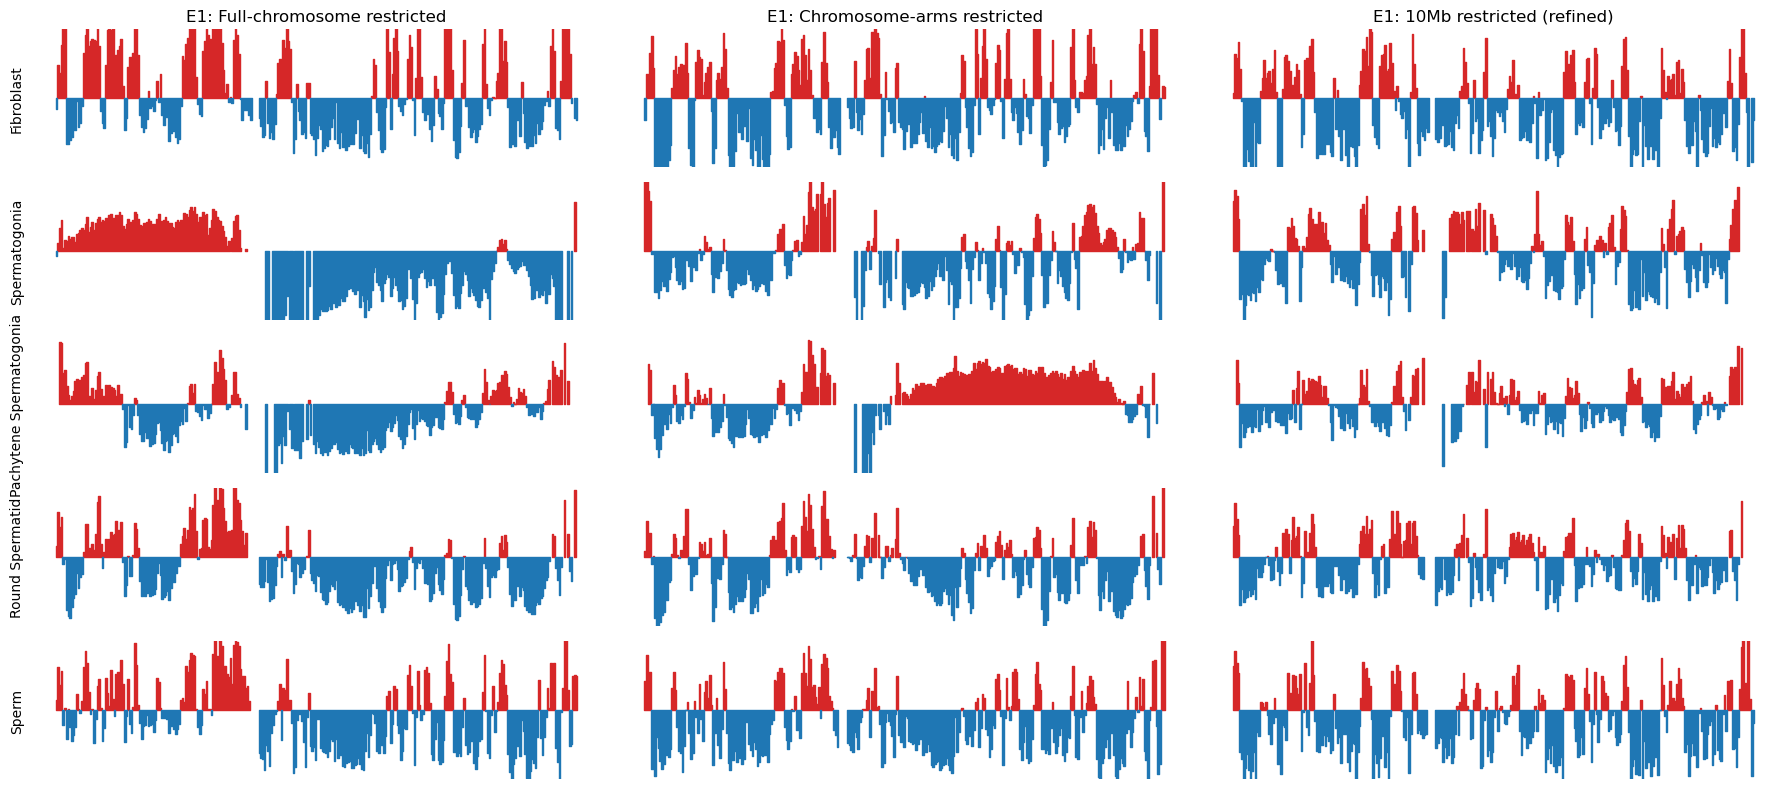

In [48]:
#| label: e1-fullmerged-all-500kb
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution. Left: Chromosome-arm restricted E1. Right: 10Mb window restricted E1."
#| column: page-inset

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

names_abbr = {'fibroblast': 'Fibroblast', 'spermatogonia': 'Spermatogonia', 'pachytene_spermatocyte': 'Pachytene Spermatogonia', 'round_spermatid': 'Round Spermatid', 'sperm': 'Sperm'}

chrom_start = e1_track_full['start'].values
chrom_end = e1_track_full['end'].values-1

f, axs = plt.subplots(5, 3, figsize=(18, 8), sharex=True, sharey=True)

# Populate the first column
axs[0,0].set_title('E1: Full-chromosome restricted')
for i, (name, e1) in enumerate(e1_values_full.items()):
    ax = axs[i,0]
    ax.set_ylabel(names_abbr[name])

    #ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

# Populate the second column
axs[0,1].set_title('E1: Chromosome-arms restricted')
for i, (name, e1) in enumerate(e1_values.items()):
    ax = axs[i,1]
    #ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

# Populate the third column
axs[0,2].set_title('E1: 10Mb restricted (refined)')
for i, (name, e1) in enumerate(e1_values_10mb.items()):
    ax = axs[i,2]
    #ax.set_title(name)
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1

    ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
    
    

# Set y-limits for all subplots
for ax in axs.flat:
    ax.set_ylim(-0.8, 0.8)
    ax.spines[:].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('../steps/e1_plot_full.svg', bbox_inches='tight')

#### Plot matrices with compartments (round spermatid)

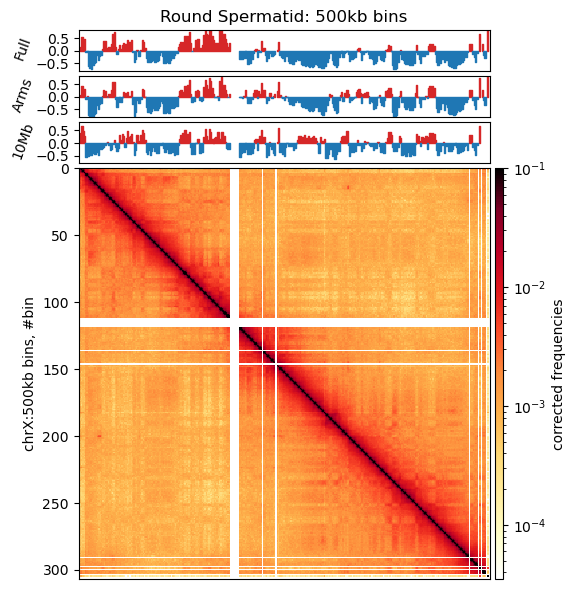

In [55]:
#| label: e1-matrix-500kb-full-arms-10mb-round_spermatid
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution for round spermatid, as well as the interaction matrix. E1 was restricted to top: Full-chromosome, middle: Chromosome-arms, bottom: 10Mb window."


import cooltools.lib.plotting
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan



clr = clrs['round_spermatid']
chrom_start, chrom_end = e1_track_full['start'].values, e1_track_full['end'].values-1
e1 = e1_values_10mb['round_spermatid']
nbins = len(clr.bins().fetch('chrX'))

f, ax = plt.subplots(
    figsize=(9,6),
)

norm = LogNorm(vmax=0.1)


e1_list = [e1_values_10mb['round_spermatid'], e1_values['round_spermatid'], e1_values_full['round_spermatid']]
e1_names = ['10Mb', 'Arms', 'Full']
colors = ['tab:red', 'tab:blue', 'tab:green']



im = ax.matshow(
    clr.matrix().fetch('chrX'),
    norm=norm,
    cmap='fall',
);
plt.axis([0,nbins,nbins,0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_ylabel('chrX:500kb bins, #bin')
ax.xaxis.set_visible(False)

for i, e1 in enumerate(e1_list):
    ax1 = divider.append_axes("top", size="10%", pad=0.05, sharex = ax)
    # weights = clr.bins()[:]['weight'].values

    # ax1.plot(e1, label='E1')

    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    #smooth_y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start/500_000
    x[1::2] = chrom_end/500_000
    y[0::2] = e1
    y[1::2] = e1
    # smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))['value'].values
    # smooth_y[0::2] = smooth_e1
    # smooth_y[1::2] = smooth_e1


    ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

    ax1.set_ylabel(e1_names[i], rotation=70)
    ax1.set_ylim(-0.8, 0.8)
    ax1.set_xticks([])

ax1.set_title('Round Spermatid: 500kb bins')


#    # Plot the sign changes on the matrix 
#     col = colors[i]
#     for i in np.where(np.diff( (pd.Series(e1)>0).astype(int)))[0]:
#         # Horisontal lines where E1 intersects 0
#         ax.plot([0,nbins],[i,i],col,lw=0.5)

#         # Vertical lines where E1 intersects 0
#         ax.plot([i,i],[0,nbins],col,lw=0.5)

plt.tight_layout()
f.canvas.draw()

#### Sliding window summed E1 compartments

To mimic the smoothing applied in the Wang et al. 2019 paper, where they slide a 400kb window in 100kb steps on the obs/exp matrix, we will similarly slide a 400kb window in 100kb steps directly on the E1 compartments.

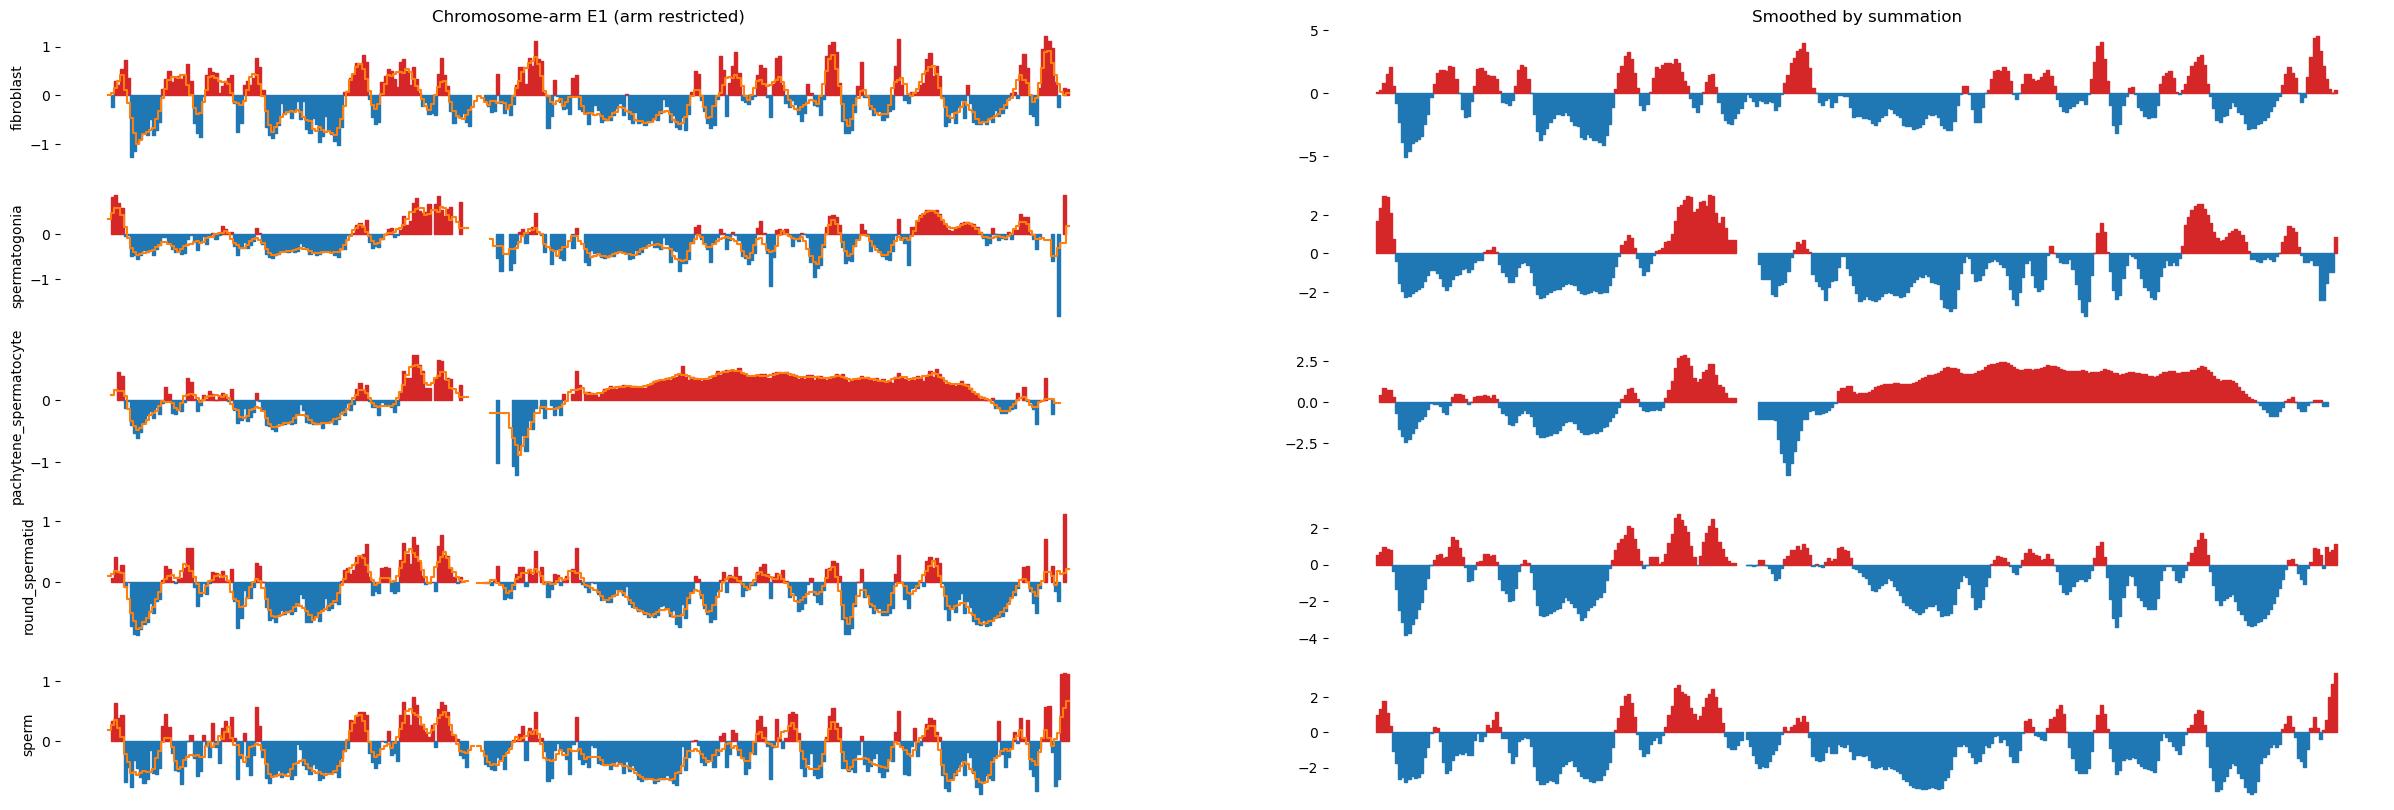

In [ ]:
#| label: e1-fullmerged-all-500kb-running-avg
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution with rolling summation, with window size 2.5Mb, step size 500Kb: Each value is now the sum of the surrounding n=5 bins."
#| column: body-outset

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy.signal.windows import triang

resolution = 500_000
window_size = 2_500_000
step_size = window_size // resolution

chrom_start = e1_track['start'].values
chrom_end = e1_track['end'].values-1

f, axs = plt.subplots(5, 2, figsize=(30, 10), sharex=True)

axs[0, 0].set_title('Chromosome-arm E1 (arm restricted)')
axs[0, 1].set_title('Smoothed by summation')

for i, (name, e1) in enumerate(e1_values.items()):
    # print(i, name, e1.size)
    smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))

    ax0 = axs[i, 0]
    ax1 = axs[i, 1]
    
    # Create stairs
    x = np.zeros(2*chrom_start.size)
    y = np.zeros(2*chrom_start.size)
    smooth_y = np.zeros(2*chrom_start.size)
    x[0::2] = chrom_start
    x[1::2] = chrom_end
    y[0::2] = e1
    y[1::2] = e1
    smooth_y[0::2] = smooth_e1['value'].values
    smooth_y[1::2] = smooth_e1['value'].values


    ax0.fill_between(x, y, 0, where=(y > 0), color='tab:red')
    ax0.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
    
    # Overlay the smoothed line (divided by 5 to make it a mean)
    ax0.plot(x, smooth_y/5, color='C1')

    ax1.fill_between(x, smooth_y, 0, where=(smooth_y > 0), color='tab:red')
    ax1.fill_between(x, smooth_y, 0, where=(smooth_y < 0), color='tab:blue')

    ax0.set_ylabel(name)
    ylim = 1.5
    #ax0.set_ylim(-ylim, ylim)
    #ax1.set_ylim(-ylim*4, ylim*4)

for ax in axs.flat:
    ax.spines[:].set_visible(False)
    ax.set_xticks([])
    #ax.set_yticks([])

# plt.tight_layout()

## 100kb resolution

### All 5 full merges

#### Load coolers

In [1]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/100000"

clrs = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs = {key: clrs[key] for key in chron_order}
clrs

names_abbr = {'fibroblast': 'Fibroblast', 'spermatogonia': 'Spermatogonia', 'pachytene_spermatocyte': 'Pachytene Spermatogonia', 'round_spermatid': 'Round Spermatid', 'sperm': 'Sperm'}

# Calculate chromstart and chromend for each bin on chrX
chrX_size = clrs['fibroblast'].chromsizes['chrX']
chrom_start = clrs['fibroblast'].bins().fetch('chrX')['start'].values
chrom_end = clrs['fibroblast'].bins().fetch('chrX')['end'].values-1
nbins = len(clrs['fibroblast'].bins().fetch('chrX'))
binsize = clrs['fibroblast'].binsize


#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [2]:
# Try with only the gc_cov for chrX

import bioframe
import pandas as pd
import os.path as op

bins = clrs['fibroblast'].bins().fetch('chrX')[:]
out_name = '../steps/rheMac10_gc_cov_X_100kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   1534 non-null   object 
 1   start   1534 non-null   int64  
 2   end     1534 non-null   int64  
 3   GC      1533 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.1+ KB
None


#### Calculate the E1 compartments

Loop: view_df, cis_eigs, e1_values

##### Plot GC covariance

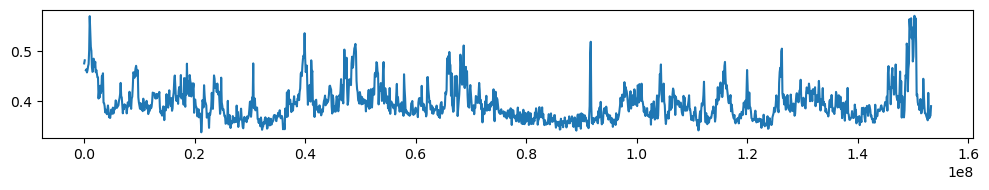

In [3]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 2))

ax.plot(gc_cov['start'],gc_cov['GC'])
plt.tight_layout()

##### Create viewframes: full, arms, 10Mb windows

In [4]:
import pandas as pd

# Fetch the chromsize of X from one of the coolers
chrX_size = clrs['fibroblast'].chromsizes['chrX']

views = {}

# Make the full view frame
views['full'] = pd.DataFrame({
    'chrom': 'chrX',
    'start': 0,
    'end': chrX_size,
    'name': 'chrX'}, index=[0])

# Divide into chromosome arms
views['arms'] = pd.DataFrame({
    'chrom': 'chrX',
    'start': [0, 59_000_001],
    'end': [59_000_000, chrX_size],
    'name': ['X_short', 'X_long']}, index=[0,1])

# Calculate in 10Mb windows
window_size = 10_000_000
start_positions = list(range(0, chrX_size, window_size))
end_positions = [min(start + window_size, chrX_size) for start in start_positions]

# Create the DataFrame
views['10Mb'] = pd.DataFrame({
    'chrom': ['chrX'] * len(start_positions),
    'start': start_positions,
    'end': end_positions,
    'name': [f'X_{i}' for i in range(len(start_positions))]
})

##### Calulate the E1 compartments

In [5]:
import cooltools

eigs = {}
e1_values = {}

for name, clr in clrs.items():
    if name not in eigs or name not in e1_values:
        eigs[name] = {} 
        e1_values[name] = {}
    for view, view_df in views.items():
        print(f"Calculating eigenvectors for {name} at {view}")
        cis_eigs = cooltools.eigs_cis(
                            clr,
                            gc_cov,
                            view_df=view_df,
                            n_eigs=1)
        eigs[name][view] = cis_eigs[1]
        e1_values[name][view] = cis_eigs[1]['E1'].values
        



Calculating eigenvectors for fibroblast at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for fibroblast at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for fibroblast at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for spermatogonia at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for pachytene_spermatocyte at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for round_spermatid at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm at full


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm at arms


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


Calculating eigenvectors for sperm at 10Mb


/home/sojern/miniconda3/envs/hic/lib/python3.12/site-packages/cooltools/lib/common.py:489: UserWarning: less than 50% of valid bins have been assigned a value
  warnings.warn("less than 50% of valid bins have been assigned a value")


#### Plot the E1 compartments

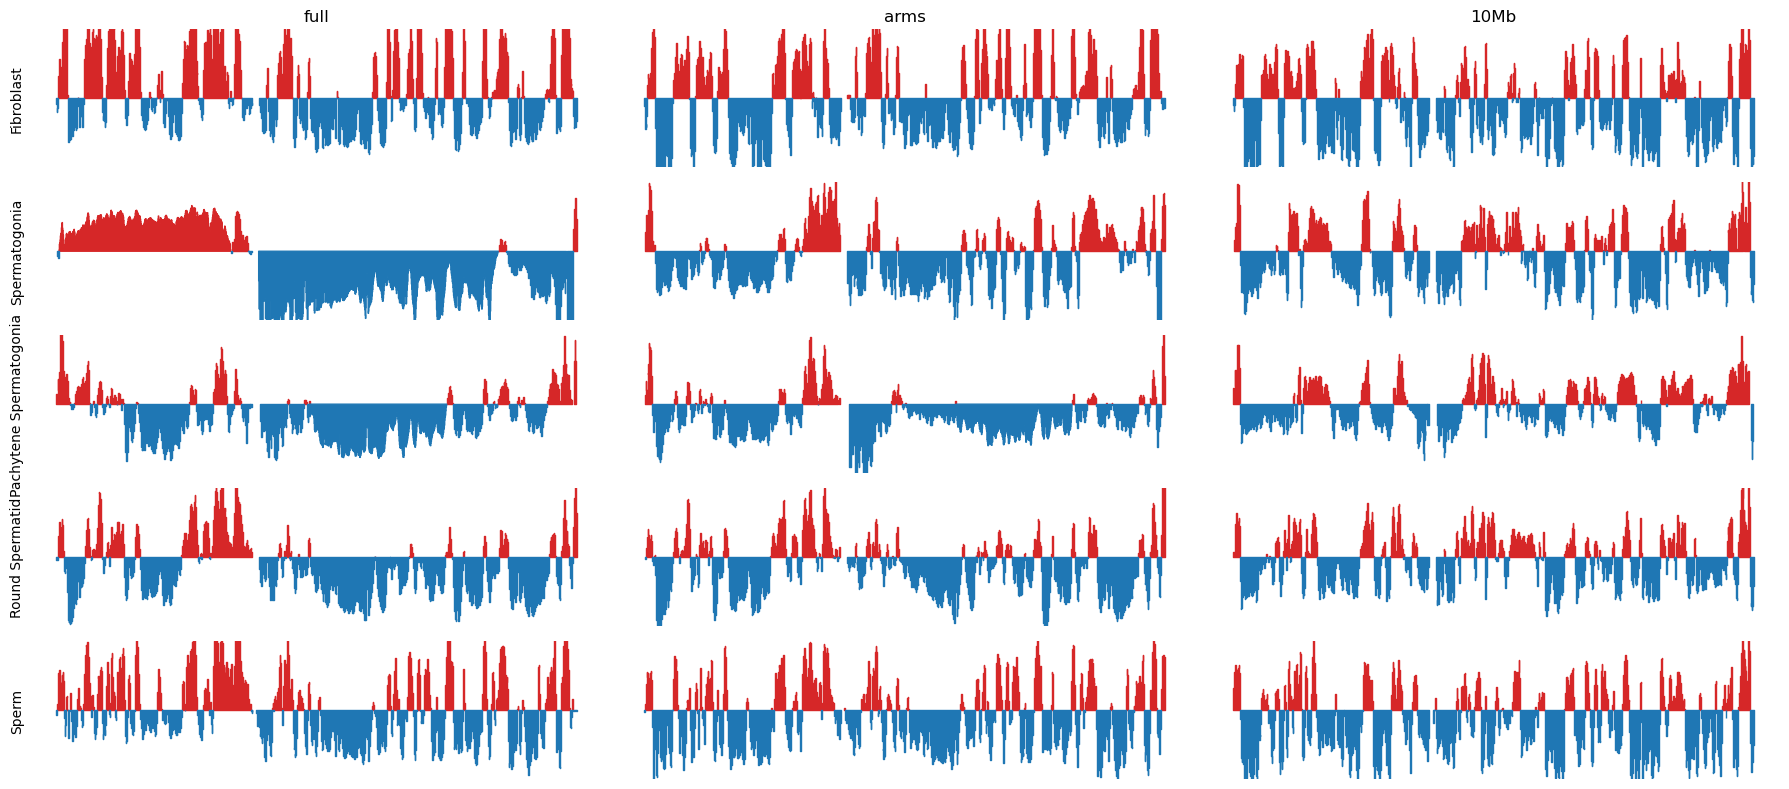

In [6]:
#| label: e1-fullmerged-all-100kb-5smoothed
#| fig-cap: "E1 eigenvector values for all merged samples at 100kb resolution. Left: Chromosomes (not restricted) Middle: Chromosome-arm restricted E1. Right: 10Mb window restricted E1.Values are smoothed with a sliding window of 5 bins, step size 1 bin."
#| column: page-inset

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, axs = plt.subplots(5, 3, figsize=(18, 8), sharex=True, sharey=True)

# Loop through eigs and e1_values to plot the E1 values
for i, (name, e1_dict) in enumerate(e1_values.items()):
    axs[i,0].set_ylabel(names_abbr[name])
    for j, (view, e1) in enumerate(e1_dict.items()):
        ax = axs[i, j]

        if i==0:
            ax.set_title(view)

        # Create stairs
        x = np.zeros(2*chrom_start.size)
        y = np.zeros(2*chrom_start.size)
        smooth_y = np.zeros(2*chrom_start.size)
        x[0::2] = chrom_start
        x[1::2] = chrom_end
        y[0::2] = e1
        y[1::2] = e1
        smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))['value'].values
        smooth_y[0::2] = smooth_e1
        smooth_y[1::2] = smooth_e1


        #ax.fill_between(x, y, 0, where=(y > 0), color='tab:red')
        #ax.fill_between(x, y, 0, where=(y < 0), color='tab:blue')
        #ax.plot(x, smooth_y/5, color='C1')

        ax.fill_between(x, smooth_y, 0, where=(smooth_y > 0), color='tab:red')
        ax.fill_between(x, smooth_y, 0, where=(smooth_y < 0), color='tab:blue')

# Set y-limits for all subplots
for ax in axs.flat:
    ax.set_ylim(-4, 4)
    ax.spines[:].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig('../steps/e1_plot_full_100kb_smoothed.svg', bbox_inches='tight')
        
    

#### Plot matrices with compartments

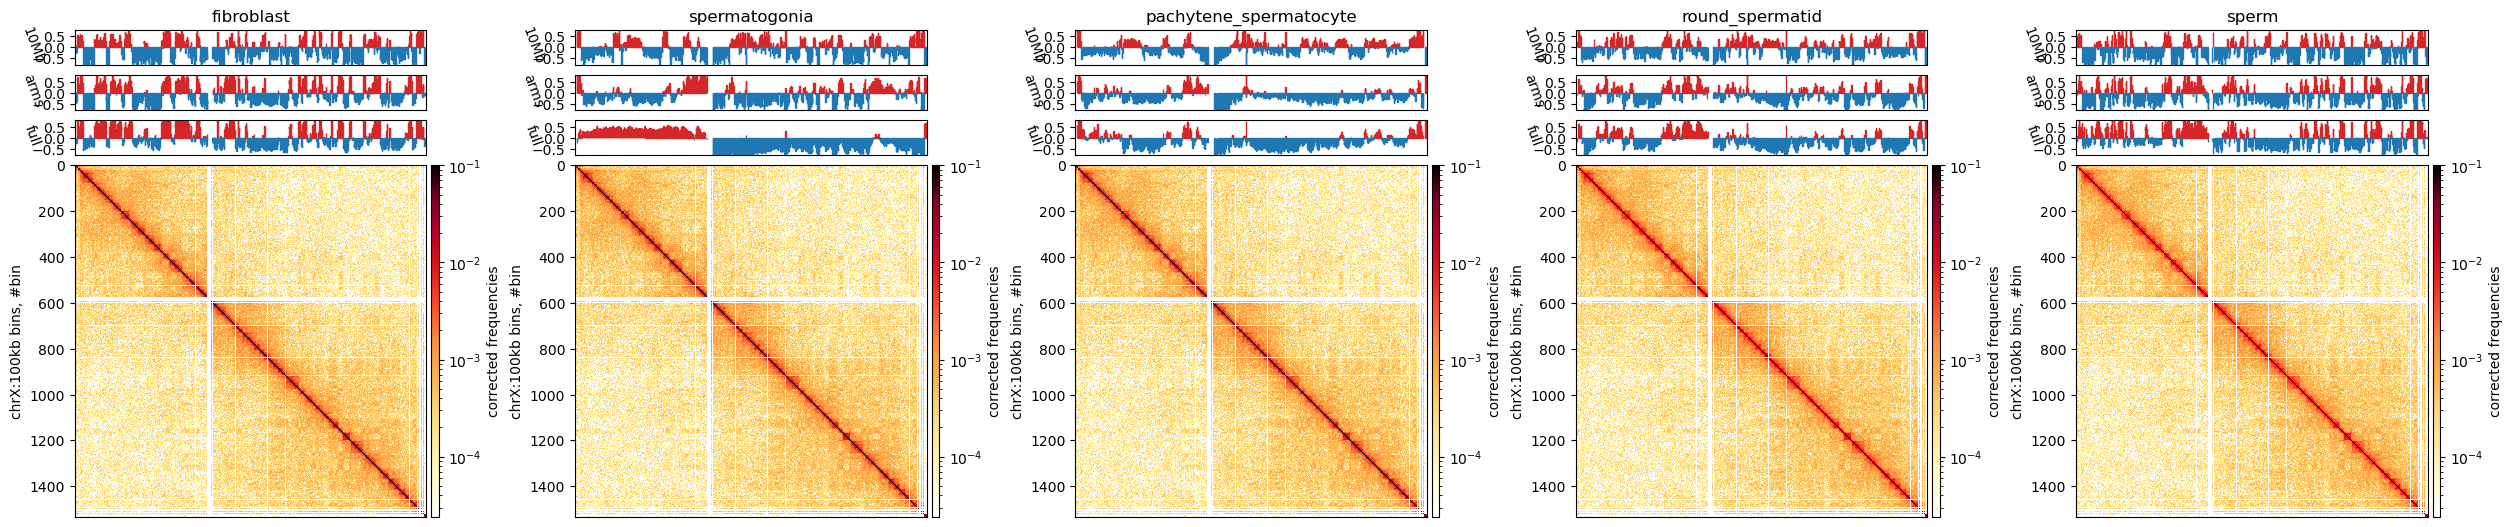

In [ ]:
#| label: e1-matrix-100kb-full-arms-10mb-all-5smoothed
#| fig-cap: "E1 eigenvector values for all merged samples at 500kb resolution for round spermatid, as well as the interaction matrix. E1 was restricted to top: Full-chromosome, middle: Chromosome-arms, bottom: 10Mb window."


import cooltools.lib.plotting
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

f, axs = plt.subplots(1,5,
    figsize=(25,10)
)

norm = LogNorm(vmax=0.1)

# Loop through the clrs and its matrix: plot the matrix on its axis
for i, (name, e1_dict) in enumerate(e1_values.items()):
    ax = axs[i]

    im = ax.matshow(
        clr.matrix().fetch('chrX'),
        norm=norm,
        cmap='fall',
    );
    ax.set_xlim(0, nbins)
    ax.set_ylim(nbins, 0)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(im, cax=cax, label='corrected frequencies');
    ax.set_ylabel('chrX:100kb bins, #bin')
    ax.xaxis.set_visible(False)

    for j, (view, e1) in enumerate(e1_dict.items()):
        ax1 = divider.append_axes("top", size="10%", pad=0.1, sharex = ax)

        # ax1.plot(e1, label='E1')

        # Create stairs
        x = np.zeros(2*chrom_start.size)
        y = np.zeros(2*chrom_start.size)
        #smooth_y = np.zeros(2*chrom_start.size)
        x[0::2] = chrom_start/binsize
        x[1::2] = chrom_end/binsize
        y[0::2] = e1
        y[1::2] = e1
        # smooth_e1 = (lambda x: x.rolling(5, 1, center=True).sum())(pd.DataFrame(e1, columns=['value']))['value'].values
        # smooth_y[0::2] = smooth_e1
        # smooth_y[1::2] = smooth_e1


        ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red')
        ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue')

        ax1.set_ylabel(view, rotation=-70)
        ax1.set_ylim(-0.8, 0.8)
        ax1.set_xticks([])

    ax1.set_title(name)

#    # Plot the sign changes on the matrix 
#     col = colors[i]
#     for i in np.where(np.diff( (pd.Series(e1)>0).astype(int)))[0]:
#         # Horisontal lines where E1 intersects 0
#         ax.plot([0,nbins],[i,i],col,lw=0.5)

#         # Vertical lines where E1 intersects 0
#         ax.plot([i,i],[0,nbins],col,lw=0.5)

# Now show the plot
f.set_layout_engine('compressed')
f.canvas.draw()
plt.show()

### Smooth the Observed/Expected matrix

Wang et al. 2019 used a 400Kb window with a step size of 100Kb to smooth the O/E matrix before calculating the E1. I have tried various different methods to smooth the interaction matrix, but I can't get dimensions of the `pixels` to match with the `bins`. Also, `cooltools.eigs_cis` need a full `cooler` to fetch data from, and I can't get it to work without a `pixels` object.

Thus, I will try smoothing the E1 values instead, as I can't really rationalize what biological difference it would make. I think I need help figuring that out. 

In [ ]:
import glob
import os.path as op
import cooler

mcools = glob.glob("../steps/bwa/PE/cool/*/*.mcool")
res = "::resolutions/100000"

clrs100kb = {op.basename(op.dirname(mcool)): cooler.Cooler(mcool+res) for mcool in mcools}

chron_order = ['fibroblast', 'spermatogonia', 'pachytene_spermatocyte', 'round_spermatid', 'sperm']

clrs100kb = {key: clrs100kb[key] for key in chron_order}
clrs100kb

{'fibroblast': <Cooler "fibroblast.mcool::/resolutions/100000">,
 'spermatogonia': <Cooler "spermatogonia.mcool::/resolutions/100000">,
 'pachytene_spermatocyte': <Cooler "pachytene_spermatocyte.mcool::/resolutions/100000">,
 'round_spermatid': <Cooler "round_spermatid.mcool::/resolutions/100000">,
 'sperm': <Cooler "sperm.mcool::/resolutions/100000">}

#### Calculate gc covariance (from the reference genome)

Do this with any of the clrs - it just needs the bins positions.

In [ ]:
import bioframe
import pandas as pd
import os.path as op

bins = clrs100kb['fibroblast'].bins().fetch('chrX')[:]
out_name = 'rheMac10_gc_cov_X_100kb.tsv'

rheMac10 = bioframe.load_fasta('../data/links/ucsc_ref/rheMac10.fa')
if not op.exists(out_name):
    print('Calculate the fraction of GC basepairs for each bin')
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], rheMac10)
    gc_cov.to_csv(out_name, index=False,sep='\t')
    print(gc_cov.info())
else: 
    print("Already exists, read from file")
    gc_cov = pd.read_csv(out_name, sep='\t')
    print(gc_cov.info())

Already exists, read from file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chrom   1534 non-null   object 
 1   start   1534 non-null   int64  
 2   end     1534 non-null   int64  
 3   GC      1533 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 48.1+ KB
None


In [ ]:
import cooler
import numpy as np

def smooth_matrix(matrix, window_size=4, step_size=1):
    n = matrix.shape[0]
    smoothed_matrix = np.zeros_like(matrix)
    
    for i in range(0, n - window_size + 1, step_size):
        for j in range(0, n - window_size + 1, step_size):
            window = matrix[i:i+window_size, j:j+window_size]
            smoothed_matrix[i:i+window_size, j:j+window_size] = np.sum(window)
    
    return smoothed_matrix

# Load the Hi-C interaction matrix from a multi-resolution .mcool file
cooler_file = '../steps/bwa/PE/cool/fibroblast/fibroblast.mcool'
clr = cooler.Cooler(cooler_file + '::resolutions/100000')

# Extract the matrix
matrix = clr.matrix(balance=True).fetch('chrX')[:]

# Smooth the matrix
smoothed_matrix = smooth_matrix(matrix, window_size=4, step_size=1)


In [ ]:
#clr.bins().fetch('chrX')[:]
clr.pixels().fetch('chrX')[:]
#print(matrix.shape)
#print(smoothed_matrix.shape)

,bin1_id,bin2_id,count
145469195,26898,26898,2013
145469196,26898,26899,171
145469197,26898,26901,75
145469198,26898,26902,100
145469199,26898,26903,187
...,...,...,...
146369705,28431,28532,2
146369706,28431,28533,1
146369707,28431,28534,2
146369708,28431,28539,1


In [ ]:
import pandas as pd
import cooler
import numpy as np

pixels = pd.DataFrame(smoothed_matrix).stack().rename_axis(['bin1_id', 'bin2_id']).reset_index(name='count')
pixels = pixels[pixels['bin1_id'] <= pixels['bin2_id']]
pixels.sort_values(['bin1_id', 'bin2_id'])[['bin1_id', 'bin2_id', 'count']].reset_index(drop=True)

,bin1_id,bin2_id,count
0,5,5,2.555538
1,5,6,2.141584
2,5,7,1.550878
3,5,8,0.864845
4,5,9,0.269873
...,...,...,...
1049071,1531,1532,4.241950
1049072,1531,1533,4.241950
1049073,1532,1532,4.241950
1049074,1532,1533,4.241950


In [ ]:
# Get the eigs

import cooltools
import pandas as pd

eigvecs, eigvals = cooltools.lib.numutils.get_eig(matrix, n=1)

ArpackNoConvergence: ARPACK error -1: No convergence (15341 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

In [ ]:
# # create a cooler for the smoothed matrix

# import cooler
# import numpy as np

# # Create a new cooler file for the smoothed matrix
# smoothed_cooler_file = cooler_file.replace('.mcool', '.smoothed.mcool')

# # Create a new cooler object
# cooler.create_cooler(smoothed_cooler_file, bins=clr.bins()[:], pixels=smoothed_matrix) 
